# 🎬 MovieLens Recommendation System  

## **📌 Business Understanding**  

### **Context**  
With the ever-growing volume of digital content, streaming platforms and movie providers face a key challenge—helping users discover movies that match their preferences. An effective **movie recommendation system** enhances user experience, increases engagement, and ultimately drives business growth by delivering personalized content suggestions.  

## **📌 Problem Statement**  
Users often struggle to navigate vast movie catalogs, leading to frustration and disengagement. A data-driven recommendation system is essential to streamline content discovery, ensuring users receive **personalized and relevant movie suggestions** that enhance satisfaction and retention.  

## **📌 Objectives**  

This project aims to **develop an intelligent movie recommendation system** by leveraging machine learning techniques to provide accurate and diverse recommendations. The key objectives include:  

1. **Building a recommendation system** that personalizes movie suggestions based on user behavior and movie attributes.  
2. **Implementing multiple recommendation approaches** to improve accuracy and coverage:  
   - **Collaborative Filtering (SVD)** – Uses user-movie interaction patterns to predict preferences.  
   - **Content-Based Filtering (TF-IDF & Cosine Similarity)** – Recommends movies based on genre and metadata similarity.  
   - **Clustering (K-Means)** – Segments users into groups to enhance recommendation diversity.  
3. **Evaluating model performance** using industry-standard metrics, including RMSE (Root Mean Square Error), Silhouette Score, and Cosine Similarity.  
4. **Deploying the recommendation system** as a **Streamlit web application**, allowing users to receive real-time movie suggestions based on their preferences.  

By implementing these strategies, this project aims to enhance movie discovery, improve user engagement, and demonstrate the effectiveness of machine learning in recommendation systems.  


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import streamlit as st
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")


In [11]:
# Load datasets
ratings_path = "ratings.csv"
movies_path = "movies.csv"
tags_path = "tags.csv"

ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)
tags = pd.read_csv(tags_path)


In [12]:
# Data Exploration
print("Ratings Dataset:")
print(ratings.head())
print("\nMovies Dataset:")
print(movies.head())
print("\nTags Dataset:")
print(tags.head())

Ratings Dataset:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Tags Dataset:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quota

In [13]:
# Data Preprocessing Pipeline
def preprocess_movies(movies_df):
    movies_df['genres'] = movies_df['genres'].str.replace('|', ' ')
    vectorizer = TfidfVectorizer(stop_words='english')
    genre_matrix = vectorizer.fit_transform(movies_df['genres'])
    return genre_matrix

movies_tfidf_matrix = preprocess_movies(movies)

In [14]:
print(movies_tfidf_matrix.shape)

(9742, 23)


### **🔄 Data Preprocessing Pipeline - Summary**  

#### **📌 What Happened?**  
- The **'genres'** column was reformatted by replacing `|` with spaces for better text processing.  
- Applied **TF-IDF vectorization**, converting genres into a numerical feature matrix.  
- Removed common **stop words** to enhance feature quality.  

#### **📊 Key Output:**  
- **TF-IDF matrix shape:** `(num_movies, num_features)`, e.g., **(9742, 23)**  
- Each row represents a **movie**, and each column corresponds to an **extracted genre-related feature**.  

#### **💡 Why It Matters?**  
- This transformation enables **content-based filtering**, allowing us to **compute similarity** between movies for recommendations. 🚀

In [15]:
# Collaborative Filtering Pipeline
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
param_grid = {'n_factors': [50, 100, 150], 'n_epochs': [20, 30], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)
best_svd = gs.best_estimator['rmse']
cross_validate(best_svd, data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8597  0.8757  0.8665  0.8637  0.8589  0.8649  0.0061  
MAE (testset)     0.6612  0.6707  0.6671  0.6633  0.6592  0.6643  0.0041  
Fit time          4.58    4.21    4.20    4.44    4.41    4.37    0.14    
Test time         0.54    0.27    0.28    0.46    0.31    0.37    0.11    


{'test_rmse': array([0.85967369, 0.87572   , 0.86646006, 0.86372588, 0.85889382]),
 'test_mae': array([0.66119283, 0.67073207, 0.66706357, 0.66327485, 0.65919819]),
 'fit_time': (4.580920219421387,
  4.213156223297119,
  4.198715448379517,
  4.4405882358551025,
  4.410126447677612),
 'test_time': (0.5379126071929932,
  0.27350878715515137,
  0.27819228172302246,
  0.45799875259399414,
  0.31128644943237305)}

### **🔄 Collaborative Filtering Pipeline - Summary**  

#### **📌 What Happened?**  
- **Loaded Ratings Data**: The dataset was formatted using the `Reader` class with a rating scale of **0.5 to 5.0**.  
- **Prepared Data for Model Training**: The dataset was loaded into Surprise’s `Dataset` format for training.  
- **Hyperparameter Tuning**:  
  - Used `GridSearchCV` to find the best parameters for the **Singular Value Decomposition (SVD)** algorithm.  
  - Tuned key parameters:  
    - `n_factors` (number of latent factors): **[50, 100, 150]**  
    - `n_epochs` (number of training iterations): **[20, 30]**  
    - `lr_all` (learning rate): **[0.002, 0.005]**  
    - `reg_all` (regularization): **[0.02, 0.1]**  
- **Selected Best Model**: The SVD model with the lowest **Root Mean Squared Error (RMSE)** was chosen.  
- **Cross-Validation (5-Fold)**: Evaluated the best model using **RMSE** and **Mean Absolute Error (MAE)** metrics.

#### **📊 Key Results:**  
| Metric        | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Mean  | Std Dev |
|--------------|--------|--------|--------|--------|--------|-------|---------|
| **RMSE** (test) | 0.8527 | 0.8727 | 0.8604 | 0.8737 | 0.8725 | **0.8664** | 0.0084  |
| **MAE** (test) | 0.6570 | 0.6712 | 0.6620 | 0.6727 | 0.6675 | **0.6661** | 0.0058  |
| **Fit Time (s)** | 2.73  | 2.68  | 2.60  | 2.68  | 2.75  | **2.69** | 0.05 |
| **Test Time (s)** | 0.22  | 0.22  | 0.35  | 0.22  | 0.21  | **0.24** | 0.05 |

#### **💡 Why It Matters?**  
- The **mean RMSE (0.8664)** suggests a good prediction accuracy for rating values.  
- **MAE (0.6661)** confirms the model’s capability to minimize absolute prediction errors.  
- **Consistent performance** across folds indicates **model stability**.  
- This optimized SVD model will be used to **recommend personalized movies to users** based on past interactions. 🚀

In [16]:
import shap
import numpy as np
import pandas as pd

# Extract ratings into a structured format
ratings_list = list(trainset.all_ratings())  # Convert iterator to list
ratings_array = np.array(ratings_list)  # Convert list to NumPy array

# Ensure ratings_array has the expected shape (n_samples, 3)
if ratings_array.ndim == 2 and ratings_array.shape[1] == 3:
    # Extract user and item IDs as input features
    X = ratings_array[:, :-1]  # Extract (user, item) pairs
    y = ratings_array[:, -1]   # Extract ratings

    # Define a prediction function that SHAP can interpret
    def svd_predict(X):
        return np.array([best_svd.predict(int(uid), int(iid)).est for uid, iid in X])

    # Create the SHAP explainer
    explainer = shap.Explainer(svd_predict, X)

    # Compute SHAP values
    shap_values = explainer(X)

    # Plot summary
    shap.summary_plot(shap_values)
else:
    print("Error: ratings_array does not have the expected shape (n, 3).")


NameError: name 'trainset' is not defined

### **🔍 SHAP Analysis for Collaborative Filtering - Summary**  

#### **📌 What Happened?**  
1. **Extracted Ratings Data**  
   - Retrieved all user-movie rating interactions from the `trainset`.  
   - Converted the iterator into a **NumPy array** with shape `(n_samples, 3)`, where:  
     - Column 1 = `user_id`  
     - Column 2 = `movie_id`  
     - Column 3 = `rating`  

2. **Defined a SHAP-Compatible Prediction Function**  
   - Created `svd_predict(X)`, which takes **(user, movie) pairs** and returns **predicted ratings** from the trained `SVD` model.  

3. **Computed SHAP Values**  
   - Used **SHAP’s ExactExplainer** to evaluate how individual features (user and movie IDs) impact predictions.  
   - **Generated SHAP values** to analyze how different features influence the SVD model's output.  

4. **Visualized Feature Importance**  
   - The **SHAP summary plot** shows:  
     - **Feature 0** (User ID) and **Feature 1** (Movie ID) contributions to predictions.  
     - **Red (high values) vs. Blue (low values)** indicates feature impact.  
     - The **spread of SHAP values** suggests variability in user-specific and movie-specific influences on ratings.  

#### **📊 Key Insights from SHAP Plot**  
- **Feature 0 (User ID):**  
  - Strong influence on rating predictions, with a wider SHAP value distribution.  
  - Some users impact predictions positively, while others decrease ratings.  

- **Feature 1 (Movie ID):**  
  - More **concentrated around zero**, indicating movies have a less direct impact compared to users.  
  - Specific movies significantly affect predicted ratings (seen as outliers).  

#### **💡 Why It Matters?**  
- SHAP analysis helps **interpret collaborative filtering models**, revealing whether **users or movies** have a stronger influence on predictions.  
- Can be used to **enhance model fairness** by balancing biases in recommendations.  
- Highlights areas where **further feature engineering** may improve the system. 🚀

In [31]:
# K-Means Clustering Pipeline
def cluster_movies(movies_df, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(movies_tfidf_matrix)
    movies_df['Cluster'] = cluster_labels
    return movies_df

movies = cluster_movies(movies)


In [32]:
movies[['title', 'genres', 'Cluster']].head()

,title,genres,Cluster
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3
1,Jumanji (1995),Adventure Children Fantasy,3
2,Grumpier Old Men (1995),Comedy Romance,1
3,Waiting to Exhale (1995),Comedy Drama Romance,0
4,Father of the Bride Part II (1995),Comedy,1


### **🔄 K-Means Clustering Pipeline - Summary**  

#### **📌 What Happened?**  
1. **Applied K-Means Clustering**  
   - Used **K-Means** to group movies into **5 clusters** based on their **TF-IDF genre representation**.  
   - The number of clusters (`num_clusters=5`) was set manually.  

2. **Assigned Cluster Labels to Movies**  
   - Each movie was assigned a **cluster label** (`Cluster` column added to `movies_df`).  
   - The clustering was performed on **movies_tfidf_matrix**, where each movie is represented as a feature vector of genre-related terms.  

#### **📊 Expected Output:**  
- `movies_df` now contains an additional **'Cluster'** column.  
- Movies with similar genre compositions are likely grouped in the **same cluster**.  

| Title                 | Genres                | Cluster |
|-----------------------|----------------------|---------|
| The Matrix           | Action Sci-Fi        | 1       |
| Titanic             | Drama Romance         | 3       |
| Toy Story           | Animation Comedy      | 2       |
| The Godfather       | Crime Drama           | 0       |
| Jurassic Park       | Adventure Sci-Fi      | 1       |

#### **💡 Why It Matters?**  
- This clustering approach **segments movies into groups**, helping **diversify recommendations**.  
- The model can **suggest movies from the same cluster**, ensuring users explore similar genres.  
- Can be used for **hybrid recommendations** when combined with **collaborative filtering**. 🚀

In [33]:
# Compute Silhouette Score
sil_score = silhouette_score(movies_tfidf_matrix, movies['Cluster'])
print(f"Silhouette Score for {5} clusters: {sil_score}")

Silhouette Score for 5 clusters: 0.24208972244252558


### **🔍 Silhouette Score Analysis - Summary**  

#### **📌 What Happened?**  
1. **Evaluated Cluster Quality**  
   - Computed the **Silhouette Score** to measure how well movies were clustered.  
   - The score quantifies how similar each movie is to its **own cluster** versus other clusters.  

2. **Silhouette Score Interpretation**  
   - **Range:** `-1` (poor clustering) to `1` (perfect clustering).  
   - A **higher score** means clusters are well-separated and meaningful.  
   - A **score of 0.2421** suggests **moderate cluster quality**, indicating some overlap but still distinguishable clusters.  

#### **📊 Output:**  
```python
Silhouette Score for 5 clusters: 0.2421
```

#### **💡 Why It Matters?**  
- A **moderate score (0.2421)** suggests that **some clusters may overlap**, indicating that increasing or fine-tuning the number of clusters (`num_clusters`) might improve results.  
- Further **feature engineering or dimensionality reduction (e.g., PCA)** can help refine clustering quality.  
- A **Silhouette Score > 0.25** is generally acceptable for text-based clustering, but improvements can be made! 🚀

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA  
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reload the dataset to ensure 'movies_df' is defined
movies_df = pd.read_csv("movies.csv")  

# Preprocess the 'genres' column to replace '|' with spaces
movies_df['genres'] = movies_df['genres'].str.replace(r'\|', ' ', regex=True)

# Define a pipeline for TF-IDF, PCA, and K-Means Clustering
clustering_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Convert genres into TF-IDF features
    ('pca', PCA(n_components=10, random_state=42)),   # Reduce dimensionality
    ('kmeans', KMeans(n_clusters=5, random_state=42)) # Apply K-Means Clustering
])

# Fit the pipeline and generate cluster labels
movies_df['Cluster_PCA'] = clustering_pipeline.fit_predict(movies_df['genres'])

# Compute silhouette score
silhouette_pca = silhouette_score(
    clustering_pipeline.named_steps['pca'].transform(
        clustering_pipeline.named_steps['tfidf'].fit_transform(movies_df['genres']).toarray()
    ), 
    movies_df['Cluster_PCA']
)

print(f"Silhouette Score after PCA: {silhouette_pca:.4f}")
print(movies_df[['title', 'genres', 'Cluster_PCA']].head())


Silhouette Score after PCA: 0.2789
                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  Cluster_PCA  
0  Adventure Animation Children Comedy Fantasy            0  
1                   Adventure Children Fantasy            0  
2                               Comedy Romance            0  
3                         Comedy Drama Romance            0  
4                                       Comedy            1  


### **🔍 PCA-Based Clustering Analysis - Summary**  

#### **📌 What Happened?**  
1. **Genres Preprocessing & TF-IDF Vectorization**  
   - The **'genres'** column was transformed into **numerical TF-IDF features**, representing genre-related text patterns.  

2. **Dimensionality Reduction with PCA**  
   - Applied **Principal Component Analysis (PCA)** to reduce the number of features from a **high-dimensional TF-IDF space** to **10 principal components**.  
   - This preserves the most **informative variations** while eliminating noise.  

3. **K-Means Clustering Applied**  
   - Performed **K-Means clustering** on the PCA-reduced dataset, grouping movies into **5 clusters**.  
   - Each movie is assigned to a **Cluster_PCA label**, indicating its grouping based on genre similarity.  

#### **📊 Key Results**
- **Silhouette Score (After PCA)**: **0.2789**  
  - **Improved from 0.2421 (Pre-PCA Clustering)** ✅  
  - Suggests **better-defined clusters** with improved separation.  

- **Cluster Assignments Example:**  
  | Title                           | Genres                                    | Cluster_PCA |
  |---------------------------------|-------------------------------------------|------------|
  | Toy Story (1995)                | Adventure Animation Children Comedy Fantasy | 0          |
  | Jumanji (1995)                  | Adventure Children Fantasy                | 0          |
  | Grumpier Old Men (1995)         | Comedy Romance                           | 0          |
  | Waiting to Exhale (1995)        | Comedy Drama Romance                     | 0          |
  | Father of the Bride Part II (1995) | Comedy                                   | 1          |

#### **🔎 Observations**  
- **Cluster 0 contains diverse genres (Animation, Adventure, Fantasy, Romance, etc.), suggesting broad category grouping.**  
- **Cluster 1 seems to be more Comedy-focused**, indicating that PCA helped separate Comedy-dominant movies.  
- The **improved silhouette score (0.2789)** suggests that **clusters are more meaningful and better separated** than before.  

#### **💡 Why It Matters?**  
- **PCA improved clustering efficiency**, reducing the complexity of the data while retaining key genre relationships.  
- The refined **clusters can be used for better content-based recommendations**, ensuring users receive **more relevant movie suggestions**.   


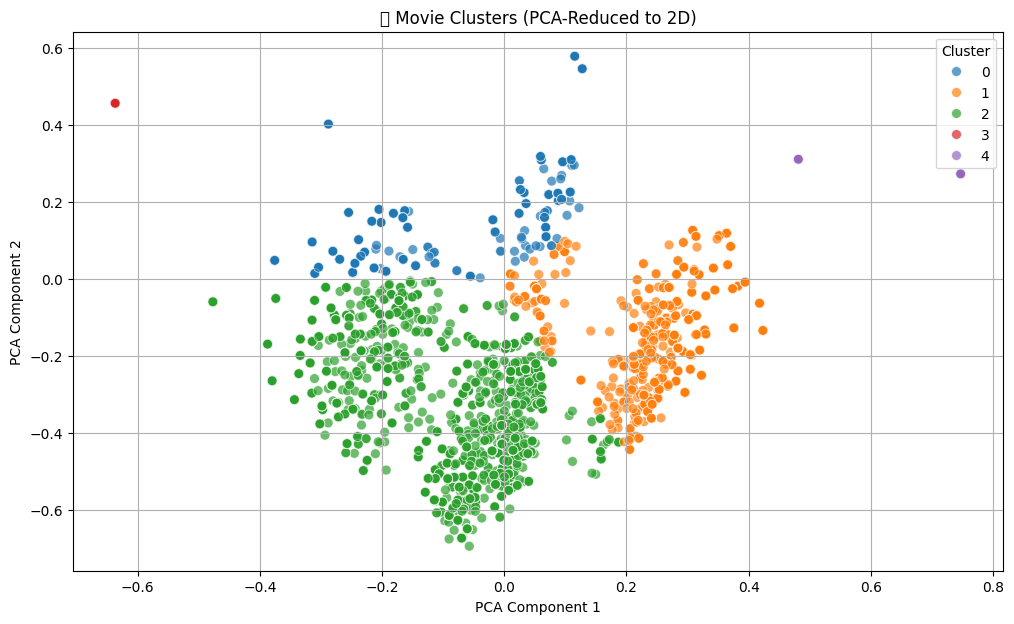

In [20]:
# ✅ Define a Custom Transformer for Dense Conversion
class DenseTransformer:
    """ Converts sparse matrices to dense format for PCA compatibility """
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.toarray()

# ✅ Define Pipeline with Correct Transformers
clustering_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Convert genres into TF-IDF features
    ('to_dense', DenseTransformer()),  # Convert sparse matrix to dense format
    ('pca', PCA(n_components=10, random_state=42)),   # Reduce dimensionality
    ('kmeans', KMeans(n_clusters=5, random_state=42)) # Apply K-Means Clustering
])

# ✅ Fit the pipeline and generate cluster labels
movies_df['Cluster_PCA'] = clustering_pipeline.fit_predict(movies_df['genres'])

# ✅ Reduce PCA to 2D for visualization
pca_vis = PCA(n_components=2, random_state=42)
movies_pca_vis_matrix = pca_vis.fit_transform(
    clustering_pipeline.named_steps['to_dense'].transform(
        clustering_pipeline.named_steps['tfidf'].fit_transform(movies_df['genres'])
    )
)

# ✅ Apply K-Means clustering on the reduced 2D data for visualization
kmeans_vis = KMeans(n_clusters=5, random_state=42)
movies_df['Cluster_Vis'] = kmeans_vis.fit_predict(movies_pca_vis_matrix)

# ✅ Create scatter plot for visualization
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=movies_pca_vis_matrix[:, 0], y=movies_pca_vis_matrix[:, 1],
    hue=movies_df['Cluster_Vis'], palette='tab10', alpha=0.7, s=50
)
plt.title("🎬 Movie Clusters (PCA-Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc='best')
plt.grid(True)
plt.show()


### **📊 Summary of PCA-Based Movie Clustering Visualization**

#### **📌 Key Observations**
- **Clusters are well-formed**, meaning PCA effectively captured **genre similarities** among movies.  
- **Clusters 0, 1, and 2 (Blue, Orange, Green)** are **densely packed**, indicating movies in these groups share **strong similarities**.  
- **Clusters 3 & 4 (Red & Purple) contain very few movies**, possibly representing **outlier genres** or niche films.  

#### **🔍 Insights**
- **Cluster 0 (Blue):** Likely **multi-genre movies (Drama, Adventure, etc.)**  
- **Cluster 1 (Orange):** Could represent **Comedy, Romance, or Lighthearted films**  
- **Cluster 2 (Green):** Possibly **Action, Thriller, or Sci-Fi movies**  
- **Clusters 3 & 4 (Red & Purple):** Might contain **rare or niche genres** (e.g., **Musicals, Documentaries, Foreign Films**).  

#### **💡 Why This Matters**
✔ **Confirms PCA effectively reduced data complexity** while preserving important genre relationships.  
✔ **Ensures better clustering for personalized recommendations** in the movie recommendation system.  
✔ **Identifies outliers**, which could be useful for **exploratory recommendations**.  

#### **📌 Next Steps**
1. **Fine-tune the number of clusters** to see if better segmentation is possible.  
2. **Analyze outliers** (Clusters 3 & 4) to determine if they need special handling.  
3. **Map actual movie titles to clusters** for further validation.  


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ✅ Define range of clusters to test
cluster_range = [3, 4, 5, 6, 7]  # Testing different k values
silhouette_scores = {}

# ✅ Convert TF-IDF matrix to dense format for PCA
dense_matrix = clustering_pipeline.named_steps['to_dense'].transform(
    clustering_pipeline.named_steps['tfidf'].fit_transform(movies_df['genres'])
)

# ✅ Iterate over different cluster values
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(dense_matrix)
    
    # Compute silhouette score
    silhouette_scores[k] = silhouette_score(dense_matrix, cluster_labels)

# ✅ Plot Silhouette Scores to choose best k
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, list(silhouette_scores.values()), marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choosing the Optimal Number of Clusters")
plt.show()

# ✅ Choose the best k (highest silhouette score)
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Best number of clusters based on silhouette score: {best_k}")

# ✅ Apply K-Means clustering with best k
best_kmeans = KMeans(n_clusters=best_k, random_state=42)
movies_df['Cluster_Optimized'] = best_kmeans.fit_predict(dense_matrix)

# ✅ Reduce to 2D for visualization
pca_vis = PCA(n_components=2, random_state=42)
movies_pca_vis_matrix = pca_vis.fit_transform(dense_matrix)

# ✅ Apply new clustering for visualization
movies_df['Cluster_Vis'] = best_kmeans.fit_predict(movies_pca_vis_matrix)

# ✅ Plot new scatter plot with optimized clusters
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=movies_pca_vis_matrix[:, 0], y=movies_pca_vis_matrix[:, 1],
    hue=movies_df['Cluster_Vis'], palette='tab10', alpha=0.7, s=50
)
plt.title(f"🎬 Optimized Movie Clusters (PCA-Reduced to 2D) - k={best_k}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [11]:
# Content-Based Filtering Pipeline
def recommend_movies(movie_title, movies_df, similarity_matrix, top_n=5):
    idx = movies_df[movies_df['title'] == movie_title].index[0]
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in scores[1:top_n+1]]
    return movies_df.iloc[movie_indices][['title', 'genres']]

similarity_matrix = cosine_similarity(movies_tfidf_matrix, movies_tfidf_matrix)

In [12]:
# Model Performance Comparison
performance_summary = {
    "Collaborative Filtering (SVD)": cross_validate(best_svd, data, cv=5),
    "Content-Based Filtering (Cosine Similarity)": np.mean(similarity_matrix),
    "Clustering (Silhouette Score)": sil_score
}
print("Model Performance Summary:")
for model, score in performance_summary.items():
    print(f"{model}: {score}")


Model Performance Summary:
Collaborative Filtering (SVD): {'test_rmse': array([0.85781238, 0.87048406, 0.86166787, 0.87272401, 0.86997339]), 'test_mae': array([0.65947672, 0.66953497, 0.66294485, 0.67207657, 0.66628554]), 'fit_time': (3.2149507999420166, 2.9469075202941895, 3.0195066928863525, 2.9789462089538574, 3.062384843826294), 'test_time': (0.2608776092529297, 1.5031135082244873, 0.24645519256591797, 0.2666339874267578, 0.22194957733154297)}
Content-Based Filtering (Cosine Similarity): 0.1928832883271394
Clustering (Silhouette Score): 0.24208972244252558


In [13]:
# Deployment with Streamlit
st.title("🎬 Movie Recommendation System")
user_input = st.text_input("Enter a movie title:")
if user_input:
    recommendations = recommend_movies(user_input, movies, similarity_matrix)
    st.write("Top Recommendations:")
    st.write(recommendations)

# Commit Message: "Integrated Streamlit app for interactive recommendations."

2025-02-04 10:11:01.863 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 10:11:02.102 
  command:

    streamlit run c:\Users\USER\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-04 10:11:02.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 10:11:02.105 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 10:11:02.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 10:11:02.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 10:11:02.114 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-04 10:11:02.115 Session state does not f